# Extra bonus experiment-cifar10
zhao xinyi
2022.5.2

In [1]:
import os
from slbi_toolbox_adam import SLBI_ToolBox
from utils import *
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import random
from vgg import VGG_A_BatchNorm
from get_small_model import *
import matplotlib.pyplot as plt

from plot import CNNLayerVisualization

/home/newdisk/zxy/zxy_virtualenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batchsize = 128
max_epoch = 20
lr = 4e-2
kappa = 1
mu = 500
weight_decay = 5e-4
interval = 10
betas = (0.9,0.999)
eps = 1e-8
torch.backends.cudnn.benchmark = True

In [3]:
def set_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(1234)

In [4]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

device = torch.device('cuda:0')
# model = LeNet5().to(device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,shuffle=True, num_workers=0)
validset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
validloader = torch.utils.data.DataLoader(validset, batch_size=batchsize,shuffle=True, num_workers=0)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize,shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def evaluate(model, device, valid_dataloader):
    model.eval()
    total_loss = 0.
    correct = 0.
    total_len = len(valid_dataloader.dataset)
    with torch.no_grad():
        for idx, (data, target) in enumerate(valid_dataloader):
            
            data, target = data.to(device), target.to(device)
            output = model(data) # batch_size * 1
            # total_loss += loss_fn(output, target).item()
            total_loss += F.nll_loss(output, target, reduction = "sum").item()
            pred = output.argmax(dim = 1)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    total_loss = total_loss / total_len
    acc = correct/total_len
    print("valid loss:{}, Accuracy:{}".format(total_loss, acc)) 
    return total_loss, acc

In [7]:
model = VGG_A_BatchNorm().to(device)
criterion = nn.CrossEntropyLoss()

name_list = []
layer_list = []
for name, p in model.named_parameters():
    name_list.append(name)
    print(name)
    if len(p.data.size()) == 4 or len(p.data.size()) == 2:
        layer_list.append(name)
optimizer = SLBI_ToolBox(model.parameters(), lr=lr, kappa=kappa, mu=mu, weight_decay=weight_decay)
# optimizer = SLBI_ToolBox(model.parameters(), lr=lr, kappa=kappa, mu=mu, betas=betas, eps=eps, weight_decay=weight_decay)
# optimizer =  torch.optim.SGD(model.parameters(), lr = 0.04, momentum=0.5,weight_decay=weight_decay)
optimizer.assign_name(name_list)
optimizer.initialize_slbi(layer_list)

all_num = max_epoch * len(trainloader)

total_loss = []
acc = []
valid_loss = []
valid_acc = []

print('num of all step:', all_num)
# print('num of step per epoch:', len(trainloader))
for ep in range(max_epoch):
    model.train()
    model.train()
    # descent_lr(lr, ep, optimizer, interval)
    loss_val = 0
    correct = num = 0

    for iter, pack in enumerate(trainloader):
        data, target = pack[0].to(device), pack[1].to(device)
        logits = model(data)
        loss = criterion(logits, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, pred = logits.max(1)
        loss_val += loss.item()
        correct += pred.eq(target).sum().item()
        num += data.shape[0]     
        if (iter + 1) % 1000 == 0:
            # print('*******************************')
            print('epoch : ', ep + 1)
            print('iteration : ', iter + 1,'loss : ', loss_val)
            print('Train accuracy : ', correct/num)
            loss_val = 0
            correct = num = 0
        
    total_loss.append(loss_val/num)
    acc.append(correct/num)

    total_loss_0, acc_0 = evaluate(model, device, validloader)
    valid_loss.append(total_loss_0)
    valid_acc.append(acc_0)

    optimizer.update_prune_order(ep)

evaluate_batch(model, testloader, device)

save_model_and_optimizer(model, optimizer, 'vgg_adam.pth')


features.0.weight
features.0.bias
features.1.weight
features.1.bias
features.4.weight
features.4.bias
features.5.weight
features.5.bias
features.8.weight
features.8.bias
features.9.weight
features.9.bias
features.11.weight
features.11.bias
features.12.weight
features.12.bias
features.15.weight
features.15.bias
features.16.weight
features.16.bias
features.18.weight
features.18.bias
features.19.weight
features.19.bias
features.22.weight
features.22.bias
features.23.weight
features.23.bias
features.25.weight
features.25.bias
features.26.weight
features.26.bias
classifier.0.weight
classifier.0.bias
classifier.1.weight
classifier.1.bias
classifier.3.weight
classifier.3.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias
*******************************************
lr  :  0.04
kappa  :  1
mu  :  500
betas  :  (0.9, 0.999)
eps  :  1e-08
weight_decay  :  0.0005
dampening  :  0
*******************************************
num of all step: 7820
valid loss:-1.5491508010

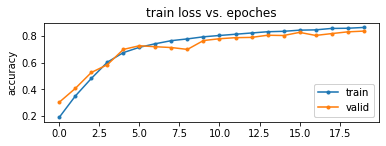

In [8]:
import matplotlib.pyplot as plt
x1 = range(0, max_epoch)
x2 = range(0, max_epoch)
y1 = acc
y2 = total_loss
y3 = valid_loss
y4 = valid_acc

# 绘制结果
plt.clf()
plt.subplot(2, 1, 1)
# plt.ylim(0.4,1)
plt.plot(x1, y1, '.-')
plt.plot(x1, y4, '.-')



plt.title('train loss vs. epoches')
plt.ylabel('accuracy')


    
l1 = plt.legend(["train", "valid"], loc='lower right')
plt.gca().add_artist(l1)

# plt.subplot(2, 1, 2)
# plt.plot(x2, y2, '.-')
# plt.plot(x2, y3, '.-')
# plt.xlabel('epoches')
# plt.ylabel('train loss')

plt.savefig("dessibli+adam_accuracy.jpg")